# Ragas (Rag Assessment)

RAG Evaluation measures the effectiveness of Retrieval-Augmented Generation systems by assessing how well retrieved documents support generated answers. The `Ragas` library simplifies this process by providing ready-to-use metrics and tools tailored for evaluating RAG pipelines. It supports both reference-based and reference-free evaluations for comprehensive insights. (reference = ground truth)

## Metrics Used

### LLM Context Precision With Reference
`LLMContextPrecisionWithReference` measures the proportion of retrieved context chunks that directly support the reference answer by using an LLM to compare each chunk to the answer.

### Non LLM Context Precision With Reference
`NonLLMContextPrecisionWithReference` measures the fraction of retrieved context chunks that match any reference context using a non-LLM similarity measure.

### LLM Context Recall
`LLMContextRecall` measures how many key facts or claims in the reference are covered by the retrieved contexts by using an LLM to check each fact.

### Non LLM Context Recall
`NonLLMContextRecall` measures the fraction of reference contexts that were successfully retrieved by comparing entities or text spans with a non-LLM similarity measure.

### Context Entity Recall
`ContextEntityRecall` computes the fraction of named entities in the reference that also appear in the retrieved contexts.

### Response Relevancy
`ResponseRelevancy` measures how directly the generated response addresses the user input by using an LLM or embeddings to score relevance.

### Faithfulness
`Faithfulness` measures the factual consistency of the response by calculating the fraction of claims in the response that are supported by the retrieved contexts.

### Faithfulness With HHEM
`FaithfulnesswithHHEM` uses a pre-trained HHEM classifier to verify each claim in the response against the retrieved contexts and computes the fraction of supported claims.

### Semantic Similarity
`SemanticSimilarity` measures the semantic closeness between the generated response and the reference by computing an embedding-based similarity score.


# Imports

In [1]:
from typing import List, Dict, Optional, Any, Union
from datetime import datetime
from sqlmodel import SQLModel, Field, create_engine, Session, select
from sqlalchemy import Column, JSON
from enum import Enum
import asyncio
from tqdm import tqdm

from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import (
    LLMContextPrecisionWithReference,
    NonLLMContextPrecisionWithReference,
    LLMContextRecall,
    NonLLMContextRecall,
    ContextEntityRecall,
    ResponseRelevancy,
    Faithfulness,
    FaithfulnesswithHHEM,
    SemanticSimilarity,
)

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/electron/PycharmProjects/fine_tune_llm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Print Versions

In [3]:
import sys
import platform
import os
import subprocess


def print_env_info():
    print("\n🌱 Welcome to your Environment Info Report! 🌱\n")

    # Python & OS
    print(f"🐍 Python:       {platform.python_implementation()} {platform.python_version()}")
    print(f"💻 Platform:     {platform.system()} {platform.release()} ({platform.machine()})\n")

    # CUDA & GPU via PyTorch
    try:
        import torch
        cuda_avail = torch.cuda.is_available()
        print(f"🚀 CUDA Available: {cuda_avail}")
        if cuda_avail:
            print(f"   • CUDA Version:   {torch.version.cuda}")
            print(f"   • cuDNN Version:  {torch.backends.cudnn.version()}")
            n_gpus = torch.cuda.device_count()
            print(f"   • GPU Count:      {n_gpus}")
            for i in range(n_gpus):
                print(f"     - GPU {i}:      {torch.cuda.get_device_name(i)}")
    except ImportError:
        print("🚫 PyTorch not installed, skipping CUDA/GPU info")

    # nvcc (if available)
    try:
        out = subprocess.check_output(['nvcc', '--version'], stderr=subprocess.STDOUT)
        release = [l for l in out.decode().splitlines() if "release" in l]
        print(f"\n📦 nvcc: {release[-1].strip()}")
    except Exception:
        print("\n📦 nvcc: not found in PATH")

    # nvidia-smi
    try:
        out = subprocess.check_output([
            'nvidia-smi',
            '--query-gpu=name,driver_version,memory.total',
            '--format=csv,noheader'], stderr=subprocess.DEVNULL
        ).decode().strip().splitlines()
        print("\n📊 nvidia-smi info:")
        for line in out:
            print("   " + line)
    except Exception:
        print("\n📊 nvidia-smi: not available")

    # Helper to show versions
    def show_ver(label, import_name=None):
        try:
            m = __import__(import_name or label)
            v = getattr(m, '__version__', None) or getattr(m, 'VERSION', None) or str(m)
            print(f"🔖 {label:<15} version: {v}")
        except ImportError:
            print(f"🔖 {label:<15} not installed")

    # Popular ML/LLM libraries
    print("\n📚 Library versions:")
    libs = [
        ('torch',      None),
        ('torchvision', None),
        ('torchaudio',  None),
        ('transformers', None),
        ('accelerate',  None),
        ('trl',         'trl'),
        ('peft',        'peft'),
        ('deepspeed',   None),
        ('bitsandbytes', None),
        ('datasets',    'datasets'),
        ('evaluate',    'evaluate'),
        ('tokenizers',  None),
        ('sentencepiece', None),
        ('huggingface_hub', None),
        ('numpy',       'numpy'),
        ('scipy',       'scipy'),
        ('pandas',      'pandas'),
        ('scikit-learn','sklearn'),
        ('wandb',       'wandb'),
        ('tensorboard', 'tensorboard'),
        ('mlflow',      'mlflow'),
        ('sqlmodel',    'sqlmodel'),
        ('ragas',    'ragas'),
        ('seaborn',    'seaborn'),
    ]
    for label, name in libs:
        show_ver(label, name)

    # Conda env and key env vars
    print("\n🔧 Conda env:", os.getenv('CONDA_DEFAULT_ENV', '(none)'))
    important_vars = ['CUDA_HOME', 'CUDA_PATH', 'LD_LIBRARY_PATH', 'HF_HOME', 'HF_DATASETS_CACHE']
    print("\n🌐 Environment variables:")
    for var in important_vars:
        print(f"   - {var:<15} = {os.getenv(var, '')}")

    print("\n✨ All set! Keep growing and training with confidence! ✨\n")

print_env_info()


🌱 Welcome to your Environment Info Report! 🌱

🐍 Python:       CPython 3.12.7
💻 Platform:     Linux 6.11.0-26-generic (x86_64)

🚀 CUDA Available: True
   • CUDA Version:   12.4
   • cuDNN Version:  90100
   • GPU Count:      1
     - GPU 0:      NVIDIA GeForce RTX 4070 Laptop GPU

📦 nvcc: Cuda compilation tools, release 12.1, V12.1.105

📊 nvidia-smi info:
   NVIDIA GeForce RTX 4070 Laptop GPU, 570.133.07, 8188 MiB

📚 Library versions:
🔖 torch           version: 2.6.0+cu124
🔖 torchvision     version: 0.21.0+cu124
🔖 torchaudio      version: 2.6.0+cu124
🔖 transformers    version: 4.51.3
🔖 accelerate      version: 1.6.0
🔖 trl             version: 0.17.0
🔖 peft            version: 0.15.2
🔖 deepspeed       not installed
🔖 bitsandbytes    version: 0.45.5
🔖 datasets        version: 3.6.0
🔖 evaluate        version: 0.4.3
🔖 tokenizers      version: 0.21.1
🔖 sentencepiece   version: 0.2.0
🔖 huggingface_hub version: 0.31.2
🔖 numpy           version: 2.2.5
🔖 scipy           version: 1.15.3
🔖 pandas

# Chat Fetcher

In [4]:
class Chat(SQLModel, table=True):
    __table_args__ = {"extend_existing": True}

    id: Optional[int] = Field(default=None, primary_key=True)
    created_at: datetime = Field(default_factory=datetime.utcnow)
    use_vllm: bool = Field(default=False)
    vllm_endpoint: Optional[str] = Field(default=None)


class ChatRole(str, Enum):
    system = "system"
    user = "user"
    assistant = "assistant"


class Message(SQLModel, table=True):
    __table_args__ = {"extend_existing": True}

    id: Optional[int] = Field(default=None, primary_key=True)
    chat_id: int = Field(foreign_key="chat.id")
    role: ChatRole = Field(description="Which chat role")
    content: List[str] = Field(default_factory=list, sa_column=Column(JSON))
    timestamp: datetime = Field(default_factory=datetime.utcnow)


class ChatFetcher:
    def __init__(self, db_url: str = "sqlite:///./chats.db") -> None:
        """
        Initialize connection to the SQLite database.
        """
        self.engine = create_engine(db_url, echo=False)
        SQLModel.metadata.create_all(self.engine)

    def fetch_all_history(self) -> List[Dict[str, Any]]:
        """
        Fetch for each chat:
          - chat_id: int
          - context: List[str]
          - question: str
          - answer: str
        Returns a list of dicts with those keys.
        """
        with Session(self.engine) as session:
            # The first message of each role by timestamp (ignoring subsequent messages in the chat)
            context_subq = (
                select(Message.content)
                .where(
                    Message.chat_id == Chat.id,
                    Message.role == ChatRole.system
                )
                .order_by(Message.timestamp)
                .limit(1)
                .scalar_subquery()
            )
            question_subq = (
                select(Message.content)
                .where(
                    Message.chat_id == Chat.id,
                    Message.role == ChatRole.user
                )
                .order_by(Message.timestamp)
                .limit(1)
                .scalar_subquery()
            )
            answer_subq = (
                select(Message.content)
                .where(
                    Message.chat_id == Chat.id,
                    Message.role == ChatRole.assistant
                )
                .order_by(Message.timestamp)
                .limit(1)
                .scalar_subquery()
            )

            stmt = (
                select(
                    Chat.id.label("chat_id"),
                    context_subq.label("context"),
                    question_subq.label("question"),
                    answer_subq.label("answer"),
                )
            )

            rows = session.exec(stmt).all()

        results: List[Dict[str, Any]] = []
        for chat_id, context, question, answer in rows:
            # context comes through as List[str] or None
            ctx: List[str] = context or []
            # question & answer are lists of strings; join into single string
            q_str = "\n".join(question) if question else ""
            a_str = "\n".join(answer) if answer else ""
            results.append({
                "chat_id": chat_id,
                "context": ctx,
                "question": q_str,
                "answer": a_str,
            })

        return results

In [5]:
chat_fetcher = ChatFetcher()
chat_history = chat_fetcher.fetch_all_history()
len(chat_history)

4

In [6]:
chat_history[0].keys()

dict_keys(['chat_id', 'context', 'question', 'answer'])

In [7]:
for ch in chat_history:
    print(f'Chat ID: {ch["chat_id"]}')
    print(f'Question: {ch["question"]}')
    print(f'Context len: {len(ch["context"])}')
    print(f'Answer: {ch["answer"]}')
    print('\n')
    print('#' * 50)
    print('\n')

Chat ID: 1
Question: I just moved in to my new apartment 3 months ago and now my landlord has increased the rent. Is that legal in Ontario?
Context len: 3
Answer: In Ontario, landlords can only increase the rent once a year by the guideline set by the Minister of Municipal Affairs and Housing. They must provide tenants with at least 90 days notice in writing of any rent increase. Since you have only been in the apartment for 3 months, it is not legal for the landlord to increase the rent at this time. You have the right to refuse the rent increase and if the landlord insists, you can contact the Landlord and Tenant Board for assistance.


##################################################


Chat ID: 2
Question: My landlord just notified me that my rent will increase effective next month. Do I have to pay him extra coming next month?
Context len: 3
Answer: Yes, if your landlord has given you proper notice of a rent increase, you will be required to pay the increased amount starting from

## Add Ground Truth (Used for Ragas Evaluation)

In [8]:
chat_history[0][
    'ground_truth'] = "In Ontario, landlords must wait at least 12 months after a tenant moves in before increasing the rent. They are also required to provide a minimum of 90 days' written notice before the increase takes effect. Therefore, raising your rent just three months after moving in is not legal."
chat_history[1][
    'ground_truth'] = "No, you are not required to pay the increased rent next month. In Ontario, landlords must provide at least 90 days' written notice using the proper form (Form N1) before a rent increase can take effect . If your landlord did not provide this notice at least 90 days in advance, the rent increase is not legally enforceable for next month."
chat_history[2][
    'ground_truth'] = "Yes, in Ontario, a landlord may legally enter a rental unit without prior notice in cases of emergency, such as a water leak, to prevent damage or address safety concerns. However, the entry should be limited to resolving the emergency, and the landlord should inform the tenant as soon as possible afterward ."
chat_history[3][
    'ground_truth'] = "In Ontario, if you pay rent weekly and are not in a fixed-term lease, you must give your landlord at least 28 days' written notice before moving out. The termination date must be the last day of your rental week—for example, if you pay rent every Monday, your termination date should be a Sunday."

# Ragas Evaluator

In [9]:
class RAGEval(SQLModel, table=True):
    __table_args__ = {"extend_existing": True}

    chat_id: str = Field(primary_key=True, description="Chat ID for this dialogue turn")
    context_precision_llm_with_ref: float
    context_precision_non_llm_with_ref: Optional[float] = None
    context_recall_llm: float
    context_recall_non_llm: Optional[float] = None
    context_entity_recall: float
    response_relevancy: float
    faithfulness: float
    faithfulness_hhem: float
    semantic_similarity: float


class RAGEvaluator:
    def __init__(
        self,
        llm: Any,
        embeddings: Any,
        db_url: str = "sqlite:///ragas_eval.db",
    ):
        """
        llm: a BaseRagasLLM instance for all LLM-based metrics
        embeddings: a BaseRagasEmbeddings instance for relevancy & similarity
        db_url: SQLModel-compatible URL to a local sqlite file
        """
        self.llm = llm
        self.embeddings = embeddings

        # Set up the SQLite database
        self.engine = create_engine(db_url, echo=False)
        SQLModel.metadata.create_all(self.engine)

        # Instantiate all the requested metrics
        self.metrics = {
            # Context Precision
            "context_precision_llm_with_ref": LLMContextPrecisionWithReference(llm=self.llm),
            "context_precision_non_llm_with_ref": NonLLMContextPrecisionWithReference(),
            # Context Recall
            "context_recall_llm": LLMContextRecall(llm=self.llm),
            "context_recall_non_llm": NonLLMContextRecall(),
            # Context Entities Recall
            "context_entity_recall": ContextEntityRecall(llm=self.llm),
            # Response Relevancy
            "response_relevancy": ResponseRelevancy(llm=self.llm, embeddings=self.embeddings),
            # Faithfulness
            "faithfulness": Faithfulness(llm=self.llm),
            "faithfulness_hhem": FaithfulnesswithHHEM(llm=self.llm),
            # Semantic Similarity
            "semantic_similarity": SemanticSimilarity(embeddings=self.embeddings),
        }

    async def evaluate(self, data: List[Dict[str, Any]]) -> List[RAGEval]:
        """
        Given rag_eval_data, computes all metrics for each record
        and persists the results into the local SQLite database.
        Returns the list of RAGEval objects.
        """
        results: List[RAGEval] = []
        # Note: SQLModel sessions are synchronous; metrics calls are async
        session = Session(self.engine)

        for item in tqdm(data):
            # Build the generic sample
            sample = SingleTurnSample(
                user_input=item["question"],
                response=item["answer"],
                reference=item["ground_truth"],
                retrieved_contexts=item["context"],
            )

            print('LLM-based context precision with reference')
            # 1. LLM-based context precision with reference
            cp_llm = await self.metrics["context_precision_llm_with_ref"].single_turn_ascore(sample)

            print('Non-LLM context precision: needs reference_contexts => skip if missing')
            # 2. Non-LLM context precision: needs reference_contexts => skip if missing
            cp_non_llm = None
            if rc := item.get("reference_context"):
                sample_refctx = SingleTurnSample(
                    retrieved_contexts=item["context"],
                    reference_contexts=rc
                )
                cp_non_llm = await self.metrics["context_precision_non_llm_with_ref"].single_turn_ascore(sample_refctx)

            print('LLM-based context recall')
            # 3. LLM-based context recall
            cr_llm = await self.metrics["context_recall_llm"].single_turn_ascore(sample)

            print('Non-LLM context recall')
            # 4. Non-LLM context recall
            cr_non_llm = None
            if rc:
                sample_refctx = SingleTurnSample(
                    retrieved_contexts=item["context"],
                    reference_contexts=rc
                )
                cr_non_llm = await self.metrics["context_recall_non_llm"].single_turn_ascore(sample_refctx)

            print('Context entity recall')
            # 5. Context entity recall
            cer = await self.metrics["context_entity_recall"].single_turn_ascore(sample)

            print('Response relevancy')
            # 6. Response relevancy
            rr = await self.metrics["response_relevancy"].single_turn_ascore(sample)

            print('Faithfulness')
            # 7. Faithfulness
            fth = await self.metrics["faithfulness"].single_turn_ascore(sample)

            print('Faithfulness with HHEM')
            # 8. Faithfulness with HHEM
            fth_hhem = await self.metrics["faithfulness_hhem"].single_turn_ascore(sample)

            print('Semantic similarity')
            # 9. Semantic similarity
            semsim = await self.metrics["semantic_similarity"].single_turn_ascore(SingleTurnSample(
                    response=item["answer"],
                    reference=item["ground_truth"],
                ))

            print('Saving evaluation results')
            # Create and persist the record
            record = RAGEval(
                chat_id=item["chat_id"],
                context_precision_llm_with_ref=cp_llm,
                context_precision_non_llm_with_ref=cp_non_llm,
                context_recall_llm=cr_llm,
                context_recall_non_llm=cr_non_llm,
                context_entity_recall=cer,
                response_relevancy=rr,
                faithfulness=fth,
                faithfulness_hhem=fth_hhem,
                semantic_similarity=semsim,
            )
            session.add(record)
            results.append(record)

        session.commit()
        session.close()
        return results

    def fetch_all(self) -> List[RAGEval]:
        """
        Retrieve all persisted RAGEval records for later analysis.
        """
        with Session(self.engine) as session:
            return session.exec(select(RAGEval)).all()

In [10]:
api_key = "INSERT-YOUR-OPENAI-TOKEN-HERE"

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-3.5-turbo", api_key=api_key))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(api_key=api_key))

evaluator = RAGEvaluator(llm=evaluator_llm, embeddings=evaluator_embeddings)

You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.


In [11]:
async def run_ragas_evaluation(evaluator, chat_history):
    print("Running RAG evaluation…")
    results = await evaluator.evaluate(chat_history)

    for r in results:
        print(f"Chat ID: {r.chat_id}")
        print(f"  Context Precision (LLM):        {r.context_precision_llm_with_ref:.3f}")
        print(f"  Context Recall (LLM):           {r.context_recall_llm:.3f}")
        print(f"  Context Entity Recall:          {r.context_entity_recall:.3f}")
        print(f"  Response Relevancy:             {r.response_relevancy:.3f}")
        print(f"  Faithfulness:                   {r.faithfulness:.3f}")
        print(f"  Faithfulness (HHEM):            {r.faithfulness_hhem:.3f}")
        print(f"  Semantic Similarity:            {r.semantic_similarity:.3f}")
        print()


In [ ]:
asyncio.run(run_ragas_evaluation(evaluator, chat_history))

## Load Saved Evaluations

In [13]:
all_records = evaluator.fetch_all()
print(f"Total stored evaluations: {len(all_records)}\n")

for rec in all_records:
    print(rec.model_dump())

Total stored evaluations: 4

{'context_precision_llm_with_ref': 0.9999999999666667, 'context_precision_non_llm_with_ref': None, 'context_recall_llm': 1.0, 'context_recall_non_llm': None, 'response_relevancy': 0.9074071555613951, 'faithfulness_hhem': 0.4, 'chat_id': '1', 'context_entity_recall': 0.2857142853061225, 'faithfulness': 0.4, 'semantic_similarity': 0.9464582351689101}
{'context_precision_llm_with_ref': 0.9999999999666667, 'context_precision_non_llm_with_ref': None, 'context_recall_llm': 1.0, 'context_recall_non_llm': None, 'response_relevancy': 0.8988886016560403, 'faithfulness_hhem': 0.0, 'chat_id': '2', 'context_entity_recall': 0.249999999375, 'faithfulness': 1.0, 'semantic_similarity': 0.908410261485283}
{'context_precision_llm_with_ref': 0.9999999999666667, 'context_precision_non_llm_with_ref': None, 'context_recall_llm': 0.5, 'context_recall_non_llm': None, 'response_relevancy': 0.8852542085183321, 'faithfulness_hhem': 0.3333333333333333, 'chat_id': '3', 'context_entity_r

# Ragas Results Visualization

In [14]:
class VisualizeRagasResults:
    """
    Generate and save visualizations for RAG evaluation metrics.
    """

    def __init__(
        self,
        records: List[RAGEval],
        output_dir: str = "plots",
    ):
        """
        :param records: List of RAGEval instances
        :param output_dir: Directory where all plots will be saved.
        """
        data = []
        for r in records:
            data.append(r.model_dump())
            
        self.df = pd.DataFrame(data)
        
        os.makedirs(output_dir, exist_ok=True)
        self.output_dir = output_dir
        
        sns.set_theme(style="whitegrid", palette="muted")

    def _save_and_show(self, fig: plt.Figure, filename: str):
        """
        Helper to save a figure and then show it.
        """
        path = os.path.join(self.output_dir, filename)
        fig.savefig(path, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    def plot_context_precision(self):
        """
        Grouped bar chart for LLM vs Non-LLM Context Precision.
        """
        df = self.df[[
            "chat_id",
            "context_precision_llm_with_ref",
            "context_precision_non_llm_with_ref"
        ]].melt(
            id_vars="chat_id",
            var_name="method",
            value_name="precision"
        )
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=df,
            x="chat_id",
            y="precision",
            hue="method",
            ax=ax
        )
        ax.set_title("Context Precision (LLM vs Non-LLM)")
        ax.set_xlabel("Chat ID")
        ax.set_ylabel("Precision")
        ax.legend(title="Method", loc="upper right")
        ax.tick_params(axis="x", rotation=45)
        self._save_and_show(fig, "context_precision.png")

    def plot_context_recall(self):
        """
        Grouped bar chart for LLM vs Non-LLM Context Recall.
        """
        df = self.df[[
            "chat_id",
            "context_recall_llm",
            "context_recall_non_llm"
        ]].melt(
            id_vars="chat_id",
            var_name="method",
            value_name="recall"
        )
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=df,
            x="chat_id",
            y="recall",
            hue="method",
            ax=ax
        )
        ax.set_title("Context Recall (LLM vs Non-LLM)")
        ax.set_xlabel("Chat ID")
        ax.set_ylabel("Recall")
        ax.legend(title="Method", loc="upper right")
        ax.tick_params(axis="x", rotation=45)
        self._save_and_show(fig, "context_recall.png")

    def plot_context_entity_recall(self):
        """
        Bar chart for Context Entity Recall per chat.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=self.df,
            x="chat_id",
            y="context_entity_recall",
            ax=ax
        )
        ax.set_title("Context Entity Recall")
        ax.set_xlabel("Chat ID")
        ax.set_ylabel("Entity Recall")
        ax.tick_params(axis="x", rotation=45)
        self._save_and_show(fig, "context_entity_recall.png")

    def plot_response_relevancy(self):
        """
        Bar chart for Response Relevancy per chat.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=self.df,
            x="chat_id",
            y="response_relevancy",
            ax=ax
        )
        ax.set_title("Response Relevancy")
        ax.set_xlabel("Chat ID")
        ax.set_ylabel("Relevancy")
        ax.tick_params(axis="x", rotation=45)
        self._save_and_show(fig, "response_relevancy.png")

    def plot_faithfulness(self):
        """
        Grouped bar chart for Faithfulness vs Faithfulness with HHEM.
        """
        df = self.df[[
            "chat_id",
            "faithfulness",
            "faithfulness_hhem"
        ]].melt(
            id_vars="chat_id",
            var_name="method",
            value_name="score"
        )
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=df,
            x="chat_id",
            y="score",
            hue="method",
            ax=ax
        )
        ax.set_title("Faithfulness Metrics")
        ax.set_xlabel("Chat ID")
        ax.set_ylabel("Score")
        ax.legend(title="Method", loc="upper right")
        ax.tick_params(axis="x", rotation=45)
        self._save_and_show(fig, "faithfulness.png")

    def plot_semantic_similarity(self):
        """
        Bar chart for Semantic Similarity per chat.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=self.df,
            x="chat_id",
            y="semantic_similarity",
            ax=ax
        )
        ax.set_title("Semantic Similarity")
        ax.set_xlabel("Chat ID")
        ax.set_ylabel("Similarity")
        ax.tick_params(axis="x", rotation=45)
        self._save_and_show(fig, "semantic_similarity.png")

    def visualize_all(self):
        """
        Generate and save all available metric visualizations.
        """
        self.plot_context_precision()
        self.plot_context_recall()
        self.plot_context_entity_recall()
        self.plot_response_relevancy()
        self.plot_faithfulness()
        self.plot_semantic_similarity()


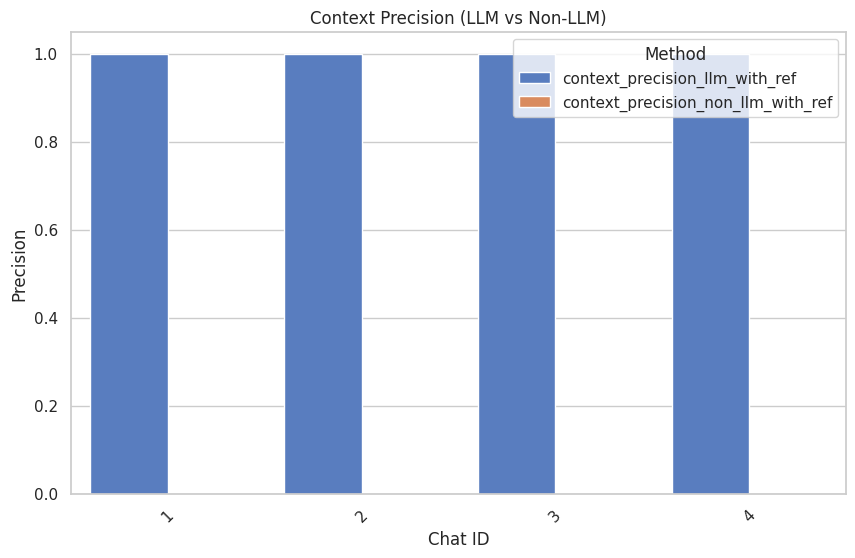

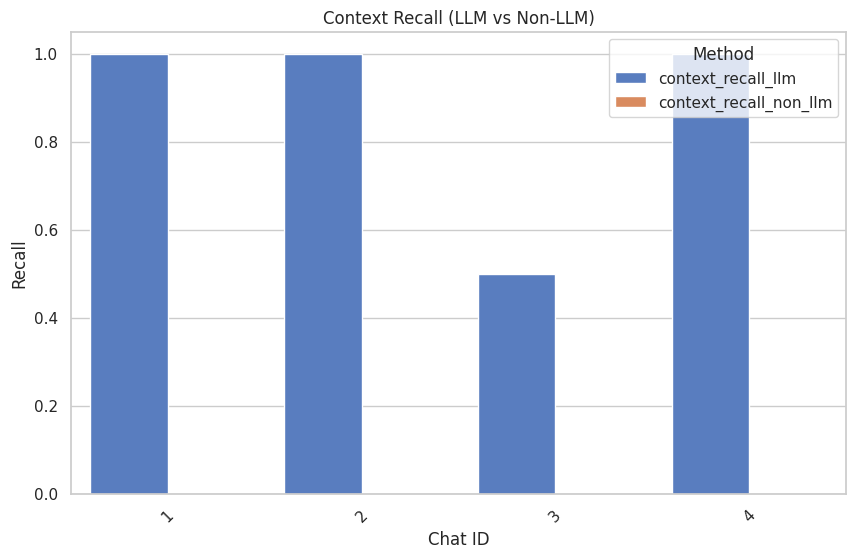

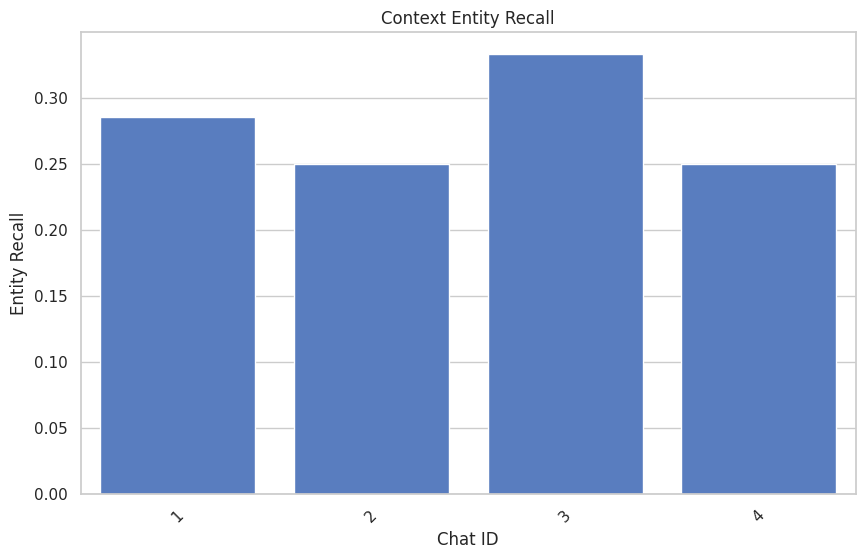

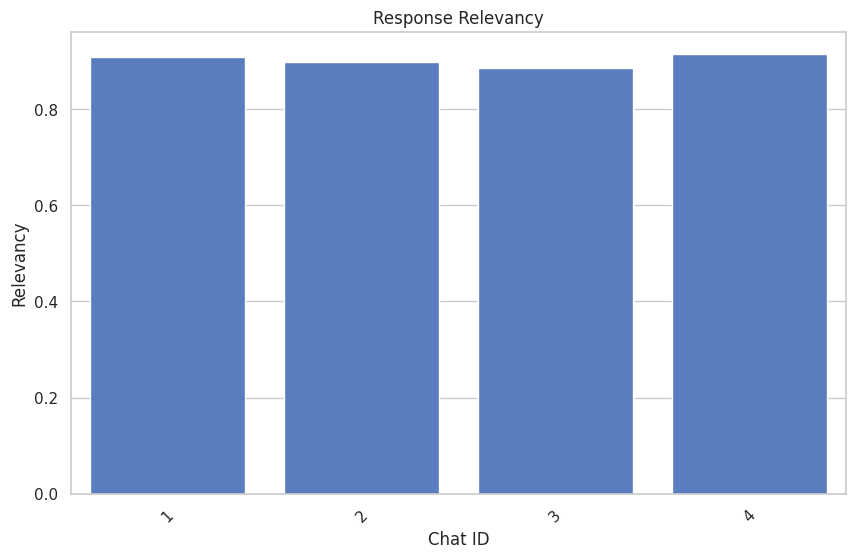

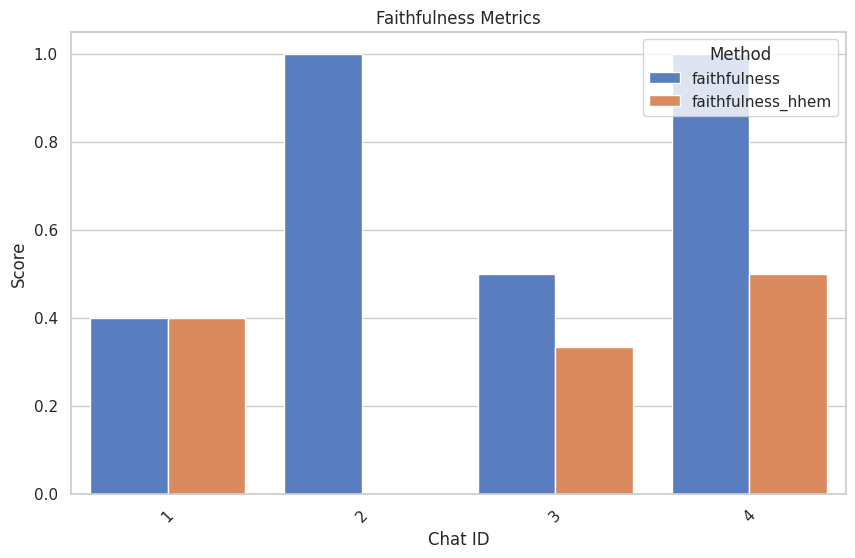

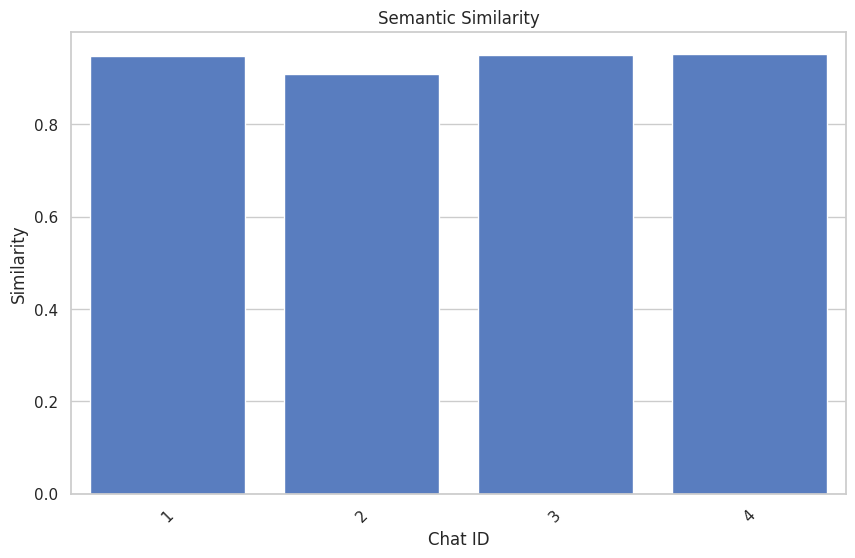

In [15]:
viz = VisualizeRagasResults(all_records, output_dir="ragas_evaluation_plots")
viz.visualize_all()